In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpl

In [ ]:
class Base:

    def __init__(self, ticker, name=""):

        self.name = name
        self.ticker = ticker
        self.df = yf.download(ticker, start="2000-01-01", group_by="column", auto_adjust=False)
        day = np.arange(1, len(self.df) + 1)
        self.df['Day'] = day
        self.df = self.df[['Day', 'Open', 'High', 'Low', 'Close']]
        self.df['return'] = np.log(self.df['Close']).diff()
        self.df.columns = [c[0] if isinstance(c, tuple) else c for c in self.df.columns]
        

    def strat(self):
        pass

    def sharpe(self, annualize: bool = True, risk_free_annual: float = 0.0, show_explain: bool = False):
        def explain():
            print("Sharpe ratio: mean excess return divided by volatility.\n"
                  "- > 1 is decent, > 2 is strong, > 3 is exceptional.\n"
                  "- Here we use log daily returns; annualized by sqrt(252) if selected.")
        r = self.df['return'].dropna()  # log returns
        rf_log_daily = np.log(1 + risk_free_annual) / 252.0
        excess = r - rf_log_daily
        sharpe_daily = excess.mean() / excess.std()
        if show_explain:
            explain()
        return (np.sqrt(252.0) * sharpe_daily) if annualize else sharpe_daily

    def sortino(self, target_return: float = 0.0, annualize: bool = True, show_explain: bool = False):
        def explain():
            print("Sortino ratio: mean excess return over downside volatility (penalizes only losses).\n"
                  "- Higher is better; less sensitive to upside spikes than Sharpe.\n"
                  "- Annualized by sqrt(252) if selected.")
        r = self.df['return'].dropna()
        downside = np.minimum(r - target_return, 0.0)
        downside_dev = np.sqrt((downside ** 2).mean())
        if downside_dev == 0:
            if show_explain:
                explain()
            return np.nan
        ratio = (r.mean() - target_return) / downside_dev
        if show_explain:
            explain()
        return (np.sqrt(252.0) * ratio) if annualize else ratio

    def omega(self, threshold: float = 0.0, show_explain: bool = False):
        def explain():
            print("Omega ratio: total gains above a threshold divided by total shortfalls below it.\n"
                  "- =1 is breakeven; >1 indicates more mass above threshold than below.\n"
                  "- Common threshold is 0 (no-return).")
        r = self.df['return'].dropna()
        gains = np.clip(r - threshold, a_min=0.0, a_max=None).sum()
        losses = np.clip(threshold - r, a_min=0.0, a_max=None).sum()
        if show_explain:
            explain()
        return np.inf if losses == 0 else (gains / losses).item()

    def max_drawdown(self, show_explain: bool = False):
        def explain():
            print("Max Drawdown: the worst peak-to-trough decline of the equity curve.\n"
                  "- Expressed as a negative fraction; closer to 0 is better.\n"
                  "- Captures tail risk not seen by volatility alone.")
        equity = np.exp(self.df['return'].fillna(0)).cumprod()
        drawdown = equity / equity.cummax() - 1.0
        mdd = drawdown.min()
        if show_explain:
            explain()
        return mdd
    
    def calmar(self, show_explain: bool = False):
        def explain():
            print("Calmar ratio: CAGR divided by absolute Max Drawdown.\n"
                  "- Higher is better; balances return with worst-case loss.\n"
                  "- Useful for trend strategies and long-term performance.")
        cagr_value = self.cagr()
        max_dd = abs(self.max_drawdown())
        if max_dd == 0:
            if show_explain:
                explain()
            return np.nan
        if show_explain:
            explain()
        return cagr_value / max_dd

    def cagr(self, show_explain: bool = False):
        def explain():
            print("CAGR: the constant annual growth rate that compounds to the final equity.\n"
                  "- Ignores path; complements drawdown-based risk measures.\n"
                  "- Not comparable across very short samples.")
        r = self.df['return'].fillna(0)
        equity = np.exp(r).cumprod()
        num_days = len(equity)
        if num_days <= 1:
            if show_explain:
                explain()
            return np.nan
        years = num_days / 252.0
        ending_value = equity.iloc[-1]
        cagr_value = ending_value ** (1.0 / years) - 1.0
        if show_explain:
            explain()
        return cagr_value
    
    def report_card(self):
        print(self.name)
        print("CAGR: ", self.cagr() * 100, '%')
        print("Sharpe: ", self.sharpe())
        print("Sortino: ", self.sortino())
        print("Omega: ", self.omega())
        print("Calmar: ", self.calmar())
        print("Max Drawdown: ", self.max_drawdown() *100, '%')


    def plot(self):
        returns = np.exp(self.df['return']).cumprod() - 1
        plt.style.use('ggplot')
        plt.plot(returns, label=self.name +" Returns")
        plt.grid(True, alpha=.3)
        plt.legend(loc=2)

In [146]:
spy = Base("QQQ", "Buy and Hold Nasdaq")

[*********************100%***********************]  1 of 1 completed


In [147]:
spy.df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6468 entries, 2000-01-03 to 2025-09-19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     6468 non-null   int64  
 1   Open    6468 non-null   float64
 2   High    6468 non-null   float64
 3   Low     6468 non-null   float64
 4   Close   6468 non-null   float64
 5   return  6467 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 353.7 KB


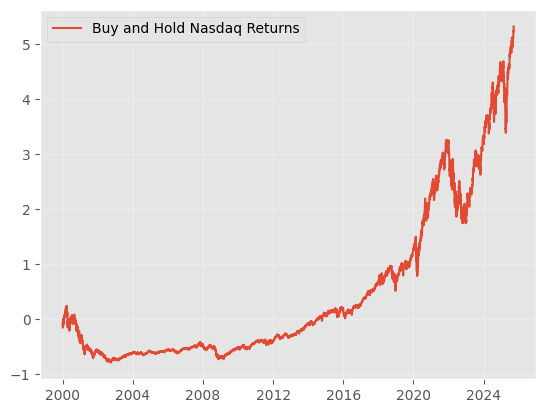

In [148]:
spy.df['Open'] = np.float32(spy.df['Open'])
spy.plot()


In [149]:
spy.report_card()
spy.omega(show_explain=True)

Buy and Hold Nasdaq
CAGR:  7.4513157725686785 %
Sharpe:  0.26674689606038865
Sortino:  0.37293868325620494
Omega:  1.0517419779362862
Calmar:  0.08981394486880746
Max Drawdown:  -82.96390703529306 %
Omega ratio: total gains above a threshold divided by total shortfalls below it.
- =1 is breakeven; >1 indicates more mass above threshold than below.
- Common threshold is 0 (no-return).


1.0517419779362862